In [1]:
import os

In [2]:
# hiwgpu1 has 4 GPU ('0', '1', '2', '3'), we use '1' here
os.environ["CUDA_VISIBLE_DEVICES"]="1"
gpu = 'gpu1'

In [3]:
from preprocess_for_single_tephi_input import *
from build_model_for_single_tephi_input import *
from post_processing_for_single_tephi_input import *
import simplejson as json
import joblib

In [4]:
# Set random seed
tf.random.set_seed(42)

In [5]:
start = datetime.now()
yyyymmdd = start.strftime('%Y%m%d')
HHMM = start.strftime('%H%M')

## Setting

In [6]:
feature_to_scale = ['TEMP', 'DWPT', 'Wdir', 'Wspd']#, 'depression']
feature_scaled = [x + '_scaled' for x in feature_to_scale]

In [7]:
copy = True # Set to True if want to copy tephi and sounding data to target_dir

img_height = 350
img_width = 250

n_layer = 90
n_feature = len(feature_scaled)

batch_size = 32

classes = [0, 1, 2] # Set to [0, 1] for binary classification
n_class = len(classes)

sequence_length : Number of timestep of tephi you apply (e.g. d+0 00Z, d+0 12Z -> 2)<br>
img_height : image height<br>
img_width : image width

nlayer : Number of pressure layer : suppose is 137 but some of the top layers are useless or duplicated, so is 90

In [8]:
# Load the fitted scaler
scaler_filename = "./scaler/scaler_f4.save"
scaler = joblib.load(scaler_filename) 

## Directory

In [9]:
public_dir = '/home/deeplearn/public_html/tephi_350x250/tephi_png_without_background_actual' # Source of actual tephi
public_dir_ec = '/home/deeplearn/public_html/tephi_350x250/tephi_png_without_background_EC' # Source of EC tephi

target_dir = '/home/deeplearn/cslau/model_input_no_bg' # Directory for training
ver_dir = '/home/deeplearn/cslau' # Directory for EC verification

checkpoint_dir = '/home/deeplearn/cslau/saved_model_%s_%s' % (yyyymmdd, gpu) # Directory to save the model
    
public_dir_model = '/home/deeplearn/public_html/%s_%s_model_%s' % (yyyymmdd, gpu, HHMM) # Directory to save the figures and csv

## Pre-processing

In [10]:
df_dv = get_DV_df('/home/deeplearn/cslau/199101-202109_max_min_DV.csv', n_class)

In [11]:
df_00 = get_sounding_df('tephi_interpolate_90_levels_00Z.csv')
df_12 = get_sounding_df('tephi_interpolate_90_levels_12Z.csv')

In [12]:
save_all_sounding_data(df_00, public_dir, feature_to_scale)
save_all_sounding_data(df_12, public_dir, feature_to_scale)

In [13]:
df_00 = remove_no_dv(df_dv, df_00)

In [14]:
df_00 = define_train_valid_test(df_00)

# Define train, valid, test for DV data
for stage in ['train', 'valid', 'test']:
    df_dv[stage] = (df_dv['date'] >= df_00[df_00[stage]]['date'].min()) & (df_dv['date'] <= df_00[df_00[stage]]['date'].max())

In [15]:
df_00, scaler = rescale_sounding_data(df_00, feature_to_scale, scaler=None)

'''
scaler_filename = "/home/deeplearn/cslau/scaler/scaler_f5.save"
if not os.path.exists(scaler_filename):
    joblib.dump(scaler, scaler_filename)
'''

In [16]:
if copy:
    for stage in ['train', 'valid', 'test']:
        for date in df_00[df_00[stage]]['date'].unique():
            copy_tephi_and_save_sounding(df_dv, df_00, public_dir, target_dir, feature_scaled, n_class, stage, date)

In [17]:
train_img, valid_img, test_img = get_tephi_path(target_dir)

In [18]:
train_npy, valid_npy, test_npy = get_sounding_path(target_dir)

In [19]:
print('Number of train_img:', len(train_img))
print('Number of valid_img:', len(valid_img))
print('Number of test_img:', len(test_img))

Number of train_img: 5268
Number of valid_img: 1129
Number of test_img: 1130


In [20]:
train_date = [i.split('.')[0][-10:] for i in train_img]
valid_date = [i.split('.')[0][-10:] for i in valid_img]
test_date = [i.split('.')[0][-10:] for i in test_img]

In [21]:
y_train, y_valid, y_test = get_y_true(target_dir)

### Get dataset

In [22]:
train_dataset, valid_dataset, test_dataset = create_dataset(target_dir, batch_size)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


## Define initial_bias for binary classification

In [23]:
if n_class == 2:
    initial_bias = get_initial_bias(y_train)
else:
    initial_bias = None

## Build model

In [24]:
model, pretrain_layer_names = create_model_2(n_class, 
                                             img_size=(img_height, img_width, 3), 
                                             data_shape=(n_layer, n_feature), 
                                             initial_bias=initial_bias)

Number of ALL trainable weights: 46
Number of trainable weights after freezing all pretrain layers: 14


## Compile the model

In [25]:
compile_model(model, n_class, lr=1e-3)

## Look at the model structure

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 350, 250, 3) 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 350, 250, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.nn.bias_add (TFOpLambda)     (None, 350, 250, 3)  0           tf.__operators__.getitem[0][0]   
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 350, 250, 64) 1792        tf.nn.bias_add[0][0]             
______________________________________________________________________________________________

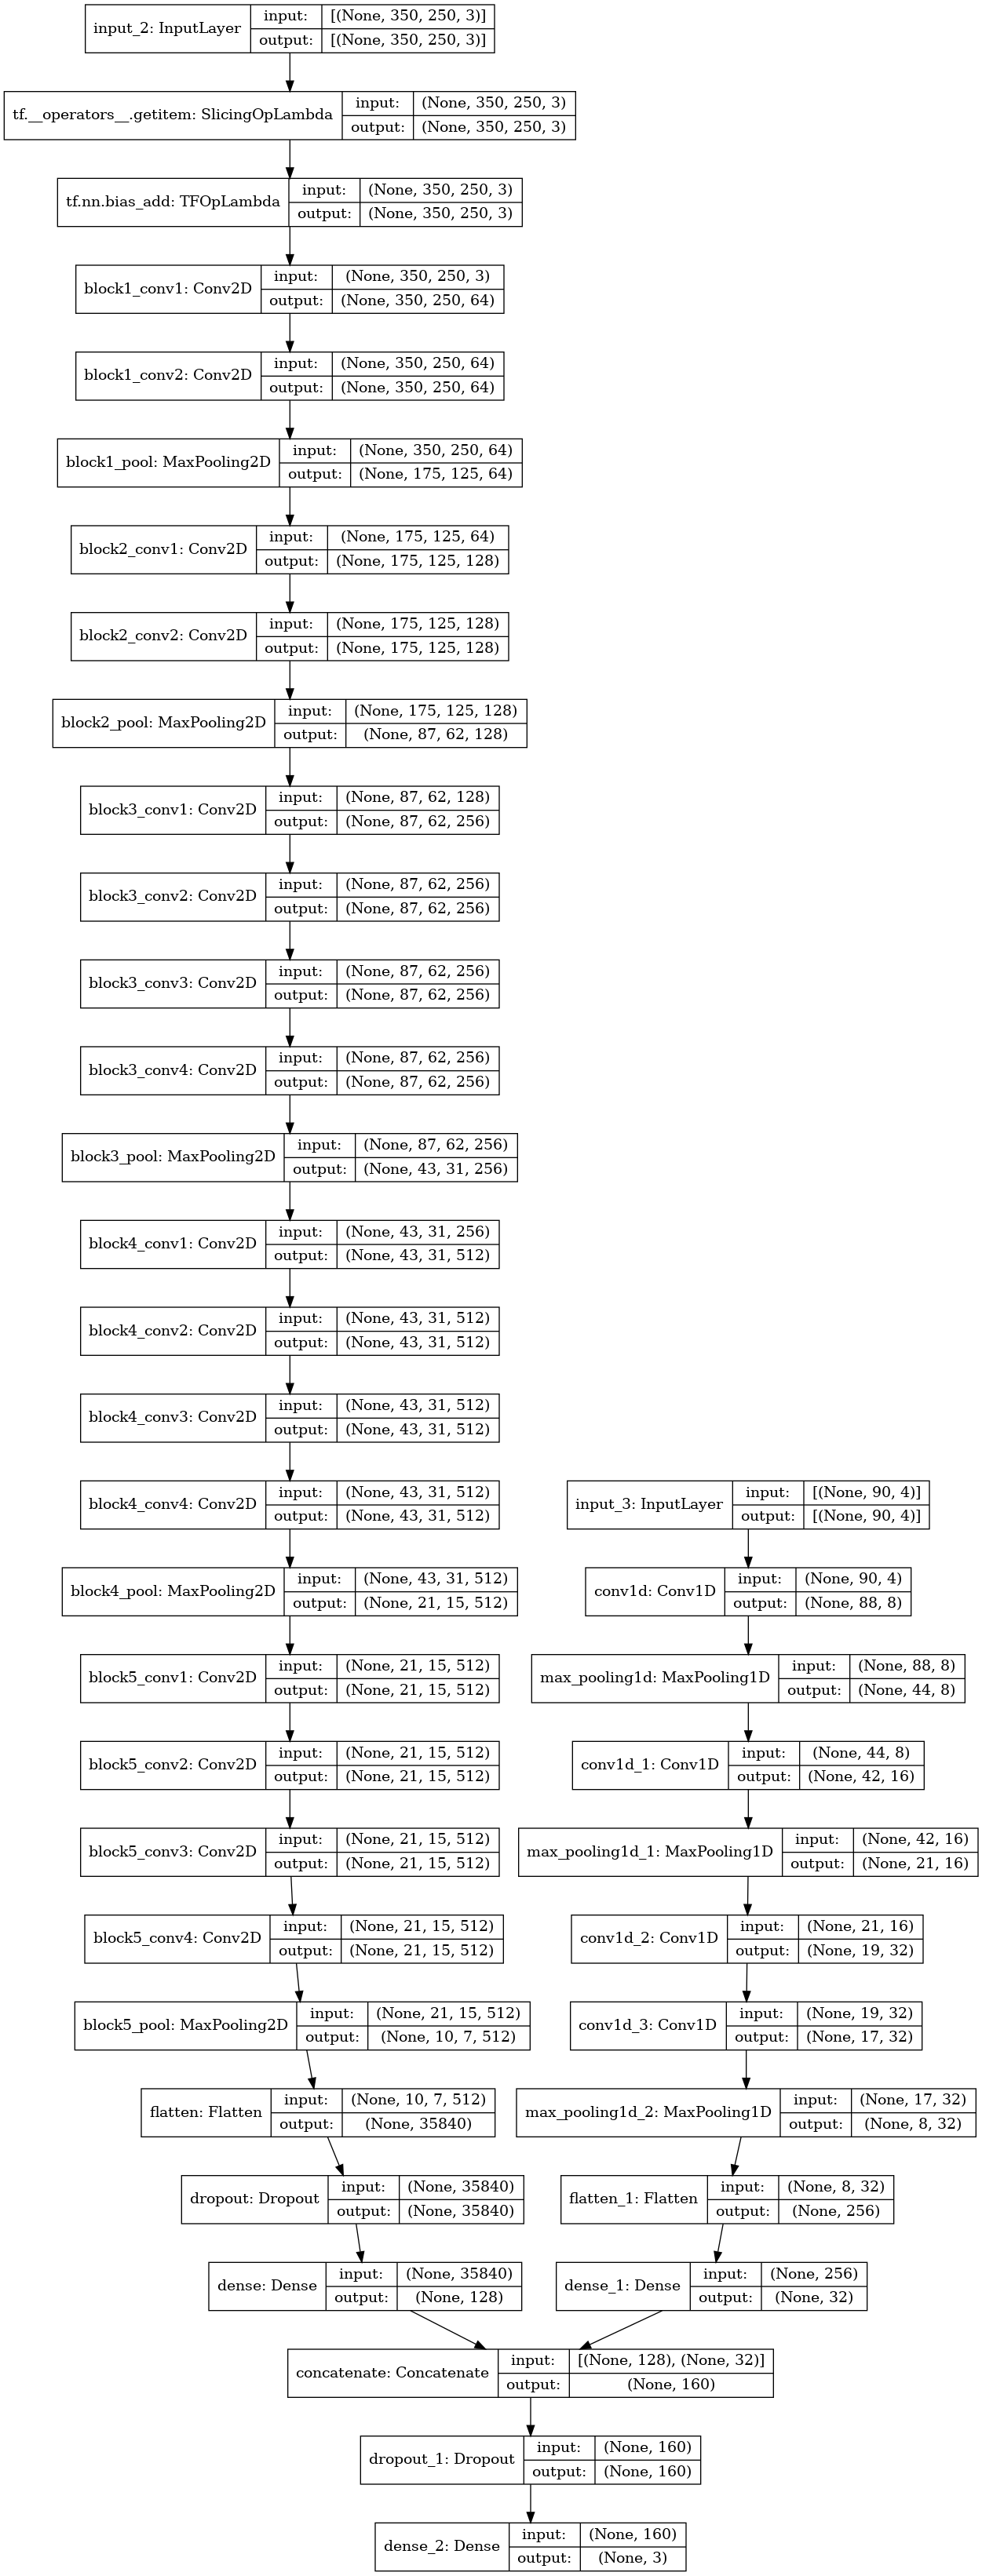

In [27]:
if not os.path.exists(public_dir_model):
    os.makedirs(public_dir_model)

plot_model(model, show_shapes=True, to_file=os.path.join(public_dir_model, 'model.png'))

## Define callback

In [28]:
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [29]:
callback_list_base = get_callback_list(monitor='val_loss', min_delta=0.01, patience=30, 
                                       factor=0.1, 
                                       checkpoint_dir=None, HHMM=None)

callback_list = get_callback_list(monitor='val_loss', min_delta=0.01, patience=30, 
                                       factor=None, 
                                       checkpoint_dir=checkpoint_dir, HHMM=HHMM)

## Define class_weight

In [30]:
class_weight = get_class_weight(y_train)

for key, value in class_weight.items():
    print('Weight for class {}: {:.2f}'.format(key, value))

Weight for class 0: 2.68
Weight for class 1: 0.50
Weight for class 2: 1.57


## Training

In [31]:
history_base = model.fit(train_dataset,
                         validation_data=(valid_dataset),
                         epochs=200,
                         callbacks=callback_list_base,
                         class_weight=class_weight
                        )

Epoch 1/200
165/165 [==============================] - 63s 276ms/step - loss: 11.7640 - accuracy: 0.4080 - val_loss: 1.2678 - val_accuracy: 0.3729
Epoch 2/200
165/165 [==============================] - 16s 95ms/step - loss: 1.4446 - accuracy: 0.4102 - val_loss: 1.2721 - val_accuracy: 0.3791
Epoch 3/200
165/165 [==============================] - 16s 95ms/step - loss: 1.4102 - accuracy: 0.4113 - val_loss: 1.3167 - val_accuracy: 0.3454
Epoch 4/200
165/165 [==============================] - 16s 95ms/step - loss: 1.3019 - accuracy: 0.4421 - val_loss: 1.3152 - val_accuracy: 0.3632
Epoch 5/200
165/165 [==============================] - 16s 95ms/step - loss: 1.3087 - accuracy: 0.4380 - val_loss: 1.2416 - val_accuracy: 0.4243
Epoch 6/200
165/165 [==============================] - 16s 95ms/step - loss: 1.3173 - accuracy: 0.4446 - val_loss: 1.2636 - val_accuracy: 0.3871
Epoch 7/200
165/165 [==============================] - 16s 95ms/step - loss: 1.2034 - accuracy: 0.4558 - val_loss: 1.2985 - val_

### Save the model (before fine-tune)

In [32]:
model.save(os.path.join(checkpoint_dir, 'model_%s_base' % HHMM))

INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model_1216_base/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model_1216_base/assets


### History (before fine-tune)

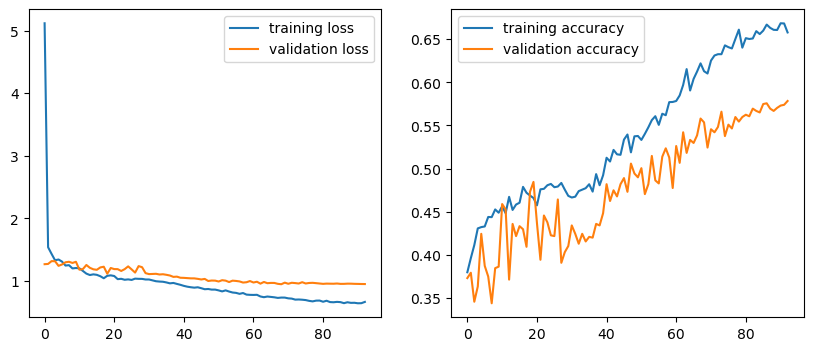

In [33]:
plot_history(history_base, n_class, to_file=os.path.join(public_dir_model, 'history.png'))

In [34]:
print_best_epoch(history_base, n_class)

min val_loss: 0.9479 ; Epoch 69

max val_accuracy: 0.5784 ; Epoch 93



## Fine-tune

In [35]:
fine_tune_2(model, pretrain_layer_names, num_set_trainable=5) # Unfreeze the last 5 layers 

### Compile the model

In [ ]:
compile_model(model, n_class, lr=1e-5)

'''
You’ll do this with the Adam optimizer, using a very low learning rate. 
The reason for using a low learning rate is that
you want to limit the magnitude of the modifications you make to the representations
of the three layers you’re fine-tuning. Updates that are too large may harm these representations.
'''

###

In [36]:
print('Number of trainable weights after unfreezing some pretrain layers:', len(model.trainable_weights))

Number of trainable weights after unfreezing some pretrain layers: 22


In [ ]:
model.summary()

In [38]:
history = model.fit(train_dataset,
                    validation_data=(valid_dataset),
                    epochs=200,
                    callbacks=callback_list,
                    class_weight=class_weight
                   )

Epoch 1/200
165/165 [==============================] - 22s 119ms/step - loss: 0.7502 - accuracy: 0.6158 - val_loss: 0.9922 - val_accuracy: 0.5199


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.001-0.99_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.001-0.99_1216/assets


Epoch 2/200
165/165 [==============================] - 17s 106ms/step - loss: 0.7462 - accuracy: 0.5926 - val_loss: 0.9859 - val_accuracy: 0.5182


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.002-0.99_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.002-0.99_1216/assets


Epoch 3/200
165/165 [==============================] - 17s 106ms/step - loss: 0.7412 - accuracy: 0.5879 - val_loss: 0.9833 - val_accuracy: 0.5438


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.003-0.98_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.003-0.98_1216/assets


Epoch 4/200
165/165 [==============================] - 17s 106ms/step - loss: 0.6958 - accuracy: 0.6304 - val_loss: 0.9750 - val_accuracy: 0.5368


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.004-0.97_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.004-0.97_1216/assets


Epoch 5/200
165/165 [==============================] - 17s 106ms/step - loss: 0.6809 - accuracy: 0.6406 - val_loss: 0.9791 - val_accuracy: 0.5518


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.005-0.98_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.005-0.98_1216/assets


Epoch 6/200
165/165 [==============================] - 17s 106ms/step - loss: 0.6840 - accuracy: 0.6365 - val_loss: 0.9654 - val_accuracy: 0.5527


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.006-0.97_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.006-0.97_1216/assets


Epoch 7/200
165/165 [==============================] - 17s 106ms/step - loss: 0.6582 - accuracy: 0.6520 - val_loss: 0.9588 - val_accuracy: 0.5660


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.007-0.96_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.007-0.96_1216/assets


Epoch 8/200
165/165 [==============================] - 17s 106ms/step - loss: 0.6370 - accuracy: 0.6668 - val_loss: 0.9728 - val_accuracy: 0.5492


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.008-0.97_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.008-0.97_1216/assets


Epoch 9/200
165/165 [==============================] - 17s 106ms/step - loss: 0.6271 - accuracy: 0.6576 - val_loss: 0.9472 - val_accuracy: 0.5934


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.009-0.95_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.009-0.95_1216/assets


Epoch 10/200
165/165 [==============================] - 17s 106ms/step - loss: 0.6126 - accuracy: 0.6811 - val_loss: 0.9779 - val_accuracy: 0.5890


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.010-0.98_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.010-0.98_1216/assets


Epoch 11/200
165/165 [==============================] - 17s 106ms/step - loss: 0.5856 - accuracy: 0.6987 - val_loss: 1.0082 - val_accuracy: 0.5819


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.011-1.01_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.011-1.01_1216/assets


Epoch 12/200
165/165 [==============================] - 17s 106ms/step - loss: 0.5663 - accuracy: 0.7168 - val_loss: 0.9842 - val_accuracy: 0.6156


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.012-0.98_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.012-0.98_1216/assets


Epoch 13/200
165/165 [==============================] - 17s 106ms/step - loss: 0.5193 - accuracy: 0.7484 - val_loss: 0.9684 - val_accuracy: 0.5890


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.013-0.97_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.013-0.97_1216/assets


Epoch 14/200
165/165 [==============================] - 17s 106ms/step - loss: 0.5250 - accuracy: 0.7457 - val_loss: 1.0020 - val_accuracy: 0.6165


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.014-1.00_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.014-1.00_1216/assets


Epoch 15/200
165/165 [==============================] - 17s 106ms/step - loss: 0.4966 - accuracy: 0.7724 - val_loss: 1.0439 - val_accuracy: 0.5917


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.015-1.04_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.015-1.04_1216/assets


Epoch 16/200
165/165 [==============================] - 17s 106ms/step - loss: 0.4683 - accuracy: 0.7799 - val_loss: 1.0473 - val_accuracy: 0.6244


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.016-1.05_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.016-1.05_1216/assets


Epoch 17/200
165/165 [==============================] - 17s 106ms/step - loss: 0.4486 - accuracy: 0.7986 - val_loss: 1.0790 - val_accuracy: 0.6333


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.017-1.08_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.017-1.08_1216/assets


Epoch 18/200
165/165 [==============================] - 17s 106ms/step - loss: 0.4419 - accuracy: 0.8064 - val_loss: 1.1103 - val_accuracy: 0.6165


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.018-1.11_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.018-1.11_1216/assets


Epoch 19/200
165/165 [==============================] - 17s 106ms/step - loss: 0.4070 - accuracy: 0.8181 - val_loss: 1.0537 - val_accuracy: 0.5961


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.019-1.05_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.019-1.05_1216/assets


Epoch 20/200
165/165 [==============================] - 17s 106ms/step - loss: 0.3797 - accuracy: 0.8348 - val_loss: 1.0568 - val_accuracy: 0.6023


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.020-1.06_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.020-1.06_1216/assets


Epoch 21/200
165/165 [==============================] - 17s 106ms/step - loss: 0.3553 - accuracy: 0.8612 - val_loss: 1.2357 - val_accuracy: 0.6218


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.021-1.24_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.021-1.24_1216/assets


Epoch 22/200
165/165 [==============================] - 17s 106ms/step - loss: 0.3178 - accuracy: 0.8816 - val_loss: 1.1639 - val_accuracy: 0.6023


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.022-1.16_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.022-1.16_1216/assets


Epoch 23/200
165/165 [==============================] - 17s 106ms/step - loss: 0.3182 - accuracy: 0.8751 - val_loss: 1.2579 - val_accuracy: 0.6262


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.023-1.26_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.023-1.26_1216/assets


Epoch 24/200
165/165 [==============================] - 17s 106ms/step - loss: 0.3010 - accuracy: 0.8809 - val_loss: 1.2140 - val_accuracy: 0.6103


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.024-1.21_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.024-1.21_1216/assets


Epoch 25/200
165/165 [==============================] - 17s 106ms/step - loss: 0.2851 - accuracy: 0.9030 - val_loss: 1.3327 - val_accuracy: 0.6333


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.025-1.33_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.025-1.33_1216/assets


Epoch 26/200
165/165 [==============================] - 17s 106ms/step - loss: 0.2814 - accuracy: 0.9164 - val_loss: 1.2830 - val_accuracy: 0.5881


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.026-1.28_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.026-1.28_1216/assets


Epoch 27/200
165/165 [==============================] - 17s 106ms/step - loss: 0.2451 - accuracy: 0.9211 - val_loss: 1.3131 - val_accuracy: 0.5979


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.027-1.31_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.027-1.31_1216/assets


Epoch 28/200
165/165 [==============================] - 17s 106ms/step - loss: 0.2268 - accuracy: 0.9259 - val_loss: 1.3328 - val_accuracy: 0.5988


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.028-1.33_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.028-1.33_1216/assets


Epoch 29/200
165/165 [==============================] - 17s 106ms/step - loss: 0.2157 - accuracy: 0.9389 - val_loss: 1.3029 - val_accuracy: 0.5828


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.029-1.30_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.029-1.30_1216/assets


Epoch 30/200
165/165 [==============================] - 17s 106ms/step - loss: 0.2089 - accuracy: 0.9390 - val_loss: 1.5095 - val_accuracy: 0.6023


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.030-1.51_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.030-1.51_1216/assets


Epoch 31/200
165/165 [==============================] - 17s 106ms/step - loss: 0.2020 - accuracy: 0.9444 - val_loss: 1.3789 - val_accuracy: 0.6014


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.031-1.38_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.031-1.38_1216/assets


Epoch 32/200
165/165 [==============================] - 17s 106ms/step - loss: 0.2011 - accuracy: 0.9421 - val_loss: 1.3802 - val_accuracy: 0.5926


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.032-1.38_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.032-1.38_1216/assets


Epoch 33/200
165/165 [==============================] - 17s 106ms/step - loss: 0.1946 - accuracy: 0.9479 - val_loss: 1.5909 - val_accuracy: 0.6165


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.033-1.59_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.033-1.59_1216/assets


Epoch 34/200
165/165 [==============================] - 17s 106ms/step - loss: 0.1800 - accuracy: 0.9547 - val_loss: 1.6055 - val_accuracy: 0.6058


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.034-1.61_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.034-1.61_1216/assets


Epoch 35/200
165/165 [==============================] - 17s 106ms/step - loss: 0.1611 - accuracy: 0.9660 - val_loss: 1.8248 - val_accuracy: 0.6262


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.035-1.82_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.035-1.82_1216/assets


Epoch 36/200
165/165 [==============================] - 17s 106ms/step - loss: 0.1638 - accuracy: 0.9699 - val_loss: 1.5782 - val_accuracy: 0.6050


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.036-1.58_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.036-1.58_1216/assets


Epoch 37/200
165/165 [==============================] - 17s 106ms/step - loss: 0.1582 - accuracy: 0.9730 - val_loss: 1.7001 - val_accuracy: 0.6076


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.037-1.70_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.037-1.70_1216/assets


Epoch 38/200
165/165 [==============================] - 17s 106ms/step - loss: 0.1485 - accuracy: 0.9738 - val_loss: 1.6689 - val_accuracy: 0.6112


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.038-1.67_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.038-1.67_1216/assets


Epoch 39/200
165/165 [==============================] - 17s 106ms/step - loss: 0.1522 - accuracy: 0.9718 - val_loss: 1.6736 - val_accuracy: 0.6005


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.039-1.67_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model.039-1.67_1216/assets


### Save the model (after fine-tune)

In [39]:
model.save(os.path.join(checkpoint_dir, 'model_%s' % HHMM))

INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model_1216/assets


INFO:tensorflow:Assets written to: /home/deeplearn/cslau/saved_model_20211125_gpu1/model_1216/assets


### History (after fine-tune)

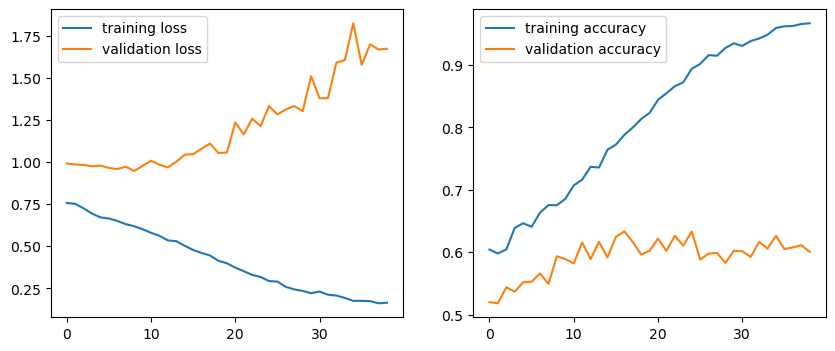

In [40]:
plot_history(history, n_class, to_file=os.path.join(public_dir_model, 'history_tuned.png'))

In [41]:
print_best_epoch(history, n_class)

min val_loss: 0.9472 ; Epoch 9

max val_accuracy: 0.6333 ; Epoch 17



###

In [42]:
end = datetime.now()

runtime = end - start

print('Start:', start)
print('End:', end)
print('Runtime:', runtime)

Start: 2021-11-25 12:16:21.307135
End: 2021-11-25 12:58:44.937475
Runtime: 0:42:23.630340


## Performance

In [43]:
y_valid_pred = model.predict(valid_dataset)
y_test_pred = model.predict(test_dataset)

In [44]:
y_valid_pred_label = get_pred_label(y_valid_pred, threshold=0.5)
y_test_pred_label = get_pred_label(y_test_pred, threshold=0.5)

In [45]:
y_valid_pred_class = get_str_class(y_valid_pred_label, n_class)
y_test_pred_class = get_str_class(y_test_pred_label, n_class)

### Validation

In [46]:
valid_result = get_result(y_valid_pred_class, y_valid, to_file=os.path.join(public_dir_model, 'valid_result.csv'))
valid_result

,class,POD,FAR,CSI,0,1,2
0,Large,0.51,0.52,0.33,7,156,151
1,Normal,0.64,0.29,0.51,50,453,134
2,Small,0.54,0.63,0.28,66,102,10


### Test

In [47]:
test_result = get_result(y_test_pred_class, y_test, to_file=os.path.join(public_dir_model, 'test_result.csv'))
test_result

,class,POD,FAR,CSI,0,1,2
0,Large,0.43,0.48,0.31,2,132,144
1,Normal,0.68,0.32,0.52,45,475,175
2,Small,0.53,0.67,0.25,52,91,14


### Cold and Hot period (only on test set)

In [48]:
cold_pred, hot_pred, cold_true, hot_true = split_cold_hot(test_date, y_test_pred, y_test)

cold_pred_label = get_pred_label(cold_pred, threshold=0.5)
hot_pred_label = get_pred_label(hot_pred, threshold=0.5)

cold_pred_class = get_str_class(cold_pred_label, n_class)
hot_pred_class = get_str_class(hot_pred_label, n_class)

test_cold_result = get_result(cold_pred_class, cold_true, to_file=os.path.join(public_dir_model, 'test_result_cold.csv'))
test_hot_result = get_result(hot_pred_class, hot_true, to_file=os.path.join(public_dir_model, 'test_result_hot.csv'))

#### Cold (Nov-Apr)

In [49]:
test_cold_result

,class,POD,FAR,CSI,0,1,2
0,Large,0.48,0.42,0.36,1,55,78
1,Normal,0.63,0.33,0.48,23,199,74
2,Small,0.64,0.63,0.31,42,61,10


#### Hot (May-Oct)

In [50]:
test_hot_result

,class,POD,FAR,CSI,0,1,2
0,Large,0.39,0.54,0.27,1,77,66
1,Normal,0.72,0.31,0.55,22,276,101
2,Small,0.30,0.77,0.15,10,30,4


### ROC curve

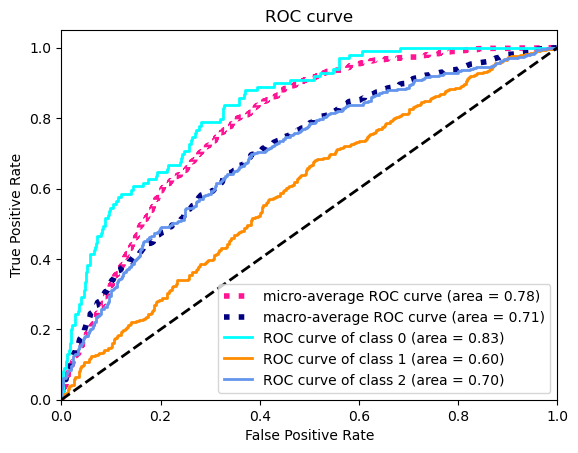

In [51]:
plot_roc_curve(y_test, y_test_pred, classes, lw=2, directory=public_dir_model) # can save to directory

### Precision-Recall curve

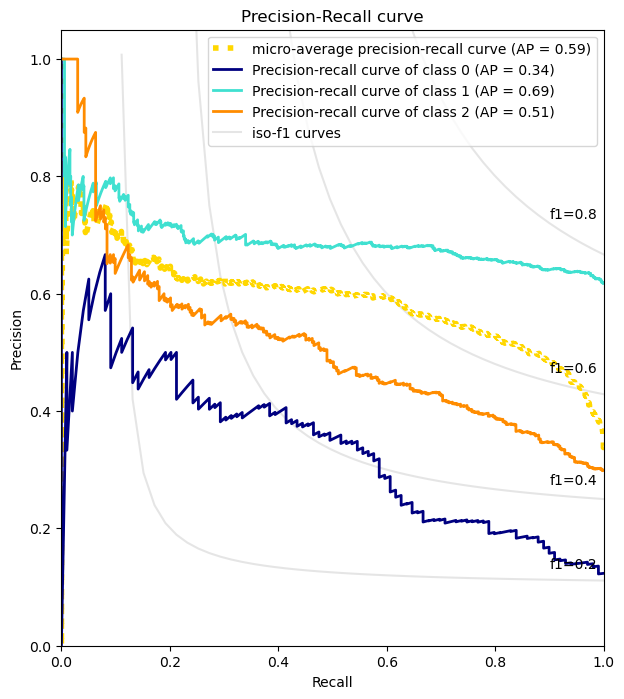

In [52]:
plot_pr_curve(y_test, y_test_pred, classes, lw=2, directory=public_dir_model) # can save to directory

### Classification report

In [53]:
print(classification_report(y_test, y_test_pred_label, target_names=None, output_dict=False))

              precision    recall  f1-score   support

           0       0.33      0.53      0.41        99
           1       0.68      0.68      0.68       698
           2       0.52      0.43      0.47       333

    accuracy                           0.59      1130
   macro avg       0.51      0.55      0.52      1130
weighted avg       0.60      0.59      0.60      1130



In [54]:
report = classification_report(y_test, y_test_pred_label, target_names=None, output_dict=True)

with open(os.path.join(public_dir_model, 'classification_report.json'), 'w') as fp:
    json.dump(report, fp, separators=(',', ':'), indent=0, ignore_nan=True)

### Review

In [55]:
df_review = get_review(y_test, y_test_pred, test_date, df_dv, verification=False, directory=public_dir_model) # can save to directory
df_review

,Date,Prob_0,Prob_1,Prob_2,Predicted DV class,Actual DV class,Actual DV,true_label,pred_label,confidence,abs_minTT,abs_maxTT,abs_DV,verification
0,2018080300,0.014193,0.456959,0.528848,Large,Normal,2.7,1,2,0.528848,29.1,31.8,2.7,False
1,2018080400,0.052644,0.845575,0.101781,Normal,Normal,5.2,1,1,0.845575,27.3,32.5,5.2,False
2,2018080500,0.009089,0.502425,0.488486,Normal,Normal,4.2,1,1,0.502425,28.9,33.1,4.2,False
3,2018080600,0.016801,0.840816,0.142383,Normal,Normal,5.0,1,1,0.840816,28.8,33.8,5.0,False
4,2018080700,0.046187,0.552272,0.401541,Normal,Large,5.8,2,1,0.552272,28.4,34.2,5.8,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1125,2021090400,0.004649,0.502614,0.492738,Normal,Large,5.7,2,1,0.502614,27.9,33.6,5.7,False
1126,2021090500,0.022128,0.527305,0.450567,Normal,Normal,4.9,1,1,0.527305,28.3,33.2,4.9,False
1127,2021090600,0.006251,0.443702,0.550047,Large,Normal,4.5,1,2,0.550047,28.0,32.5,4.5,False
1128,2021090700,0.036413,0.529779,0.433808,Normal,Normal,5.3,1,1,0.529779,28.1,33.4,5.3,False


### Reliability diagram

Accuracy: 0.5938053097345133
Mean confidence: 0.6414928


/home/deeplearn/cslau/reliability_diagram.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


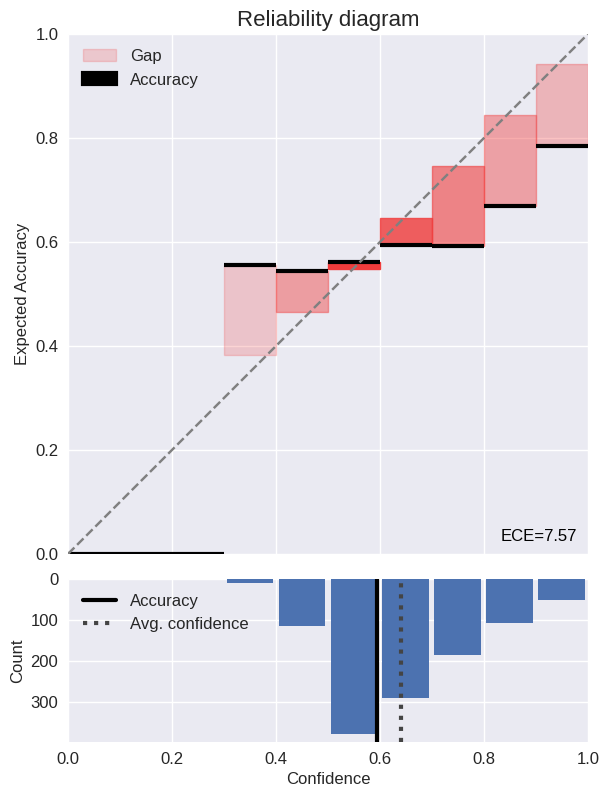

In [56]:
plot_reliability_diagram(df_review, num_bins=10, avg=True, 
                         classes=classes, start_UTC=None, lead_day=None, directory=public_dir_model) # can save to directory

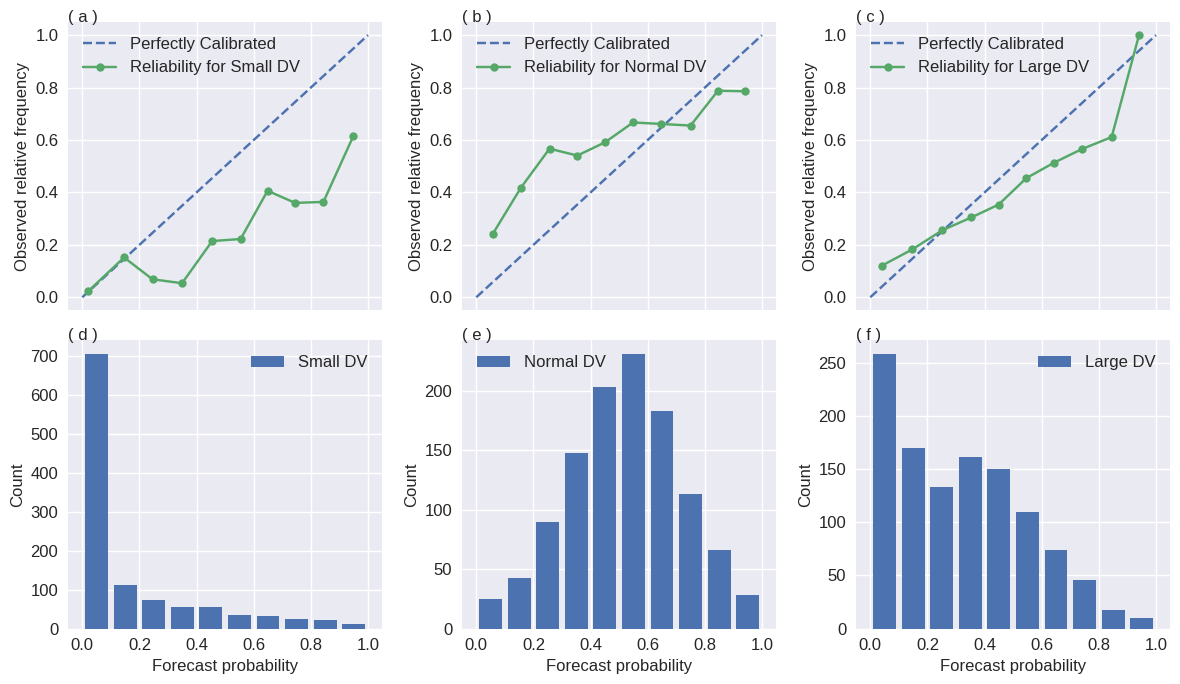

In [57]:
plot_reliability_diagram(df_review, num_bins=10, avg=False, 
                         classes=classes, start_UTC=None, lead_day=None, directory=public_dir_model) # can save to directory

In [58]:
mpl.rcParams.update(mpl.rcParamsDefault)

### Class Activation Map (CAM)

2021052300


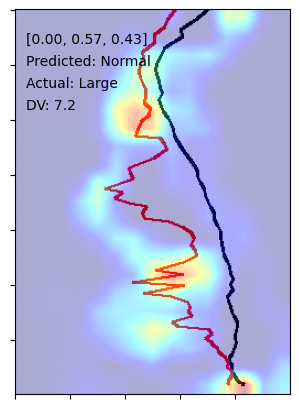

In [59]:
plot_cam('2021052300', model, df_review, test_img, test_dataset, batch_size, layer_name='block5_conv4', ax=None)

plt.show()
plt.close()

In [60]:
save = False # Set to True if want to save CAM to public_dir_model for test_date

layer_name_list = [l.name for l in model.layers if l.name[-5:-1]=='conv'] # Layers to generate CAM

if save:
    save_cam(test_date, model, df_review, test_img, test_dataset, batch_size,
             layer_name_list, classes, directory=public_dir_model, # save to directory
             start_UTC=None, lead_day=None, row=4, column=4)

## Verification : ECMWF 137 Tephi

In [ ]:
df_9day_00, df_9day_12 = get_9day_result(model, feature_to_scale, scaler, batch_size, df_dv, n_class, 
                                         public_dir_ec, ver_dir, 
                                         directory=public_dir_model) # can save to directory

In [62]:
df_9day_00

,day,class,POD,FAR,CSI,0,1,2
0,1,Large,0.20,0.24,0.18,0,6,19
1,1,Normal,0.88,0.45,0.51,15,113,78
2,1,Small,0.25,0.64,0.17,5,9,0
0,2,Large,0.17,0.27,0.16,1,5,16
1,2,Normal,0.92,0.44,0.54,12,119,80
2,2,Small,0.32,0.50,0.24,6,6,0
0,3,Large,0.14,0.35,0.13,0,7,13
1,3,Normal,0.88,0.45,0.51,13,114,82
2,3,Small,0.35,0.53,0.25,7,8,0
0,4,Large,0.13,0.41,0.12,1,8,13


### Look at the CAM for EC tephi

In [63]:
start_UTC = '00'
lead_day = 1

In [64]:
y_true, ec_pred, ec_date, ec_img, ec_dataset = verify_ecmwf(start_UTC, lead_day, model, feature_to_scale, scaler, 
                                                            batch_size, df_dv, n_class, public_dir_ec, ver_dir)

Missing: tephi-HK05_202109010000_202109020000.png
Missing: tephi-HK05_202109020000_202109030000.png
Missing: tephi-HK05_202109030000_202109040000.png


In [65]:
df_review_ec = get_review(y_true, ec_pred, ec_date, df_dv, verification=True, directory=public_dir_model) # can save to directory

2021052300


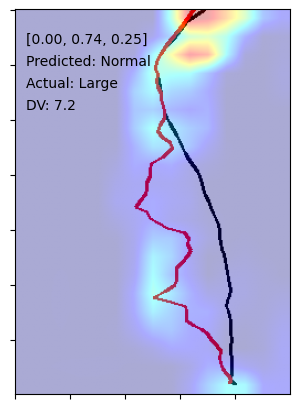

In [66]:
plot_cam('2021052300', model, df_review_ec, ec_img, ec_dataset, batch_size, layer_name='block5_conv4', ax=None)

plt.show()
plt.close()

In [ ]:
save = True # Set to True if want to save CAM to public_dir_model for ec_date

layer_name_list = [l.name for l in model.layers if l.name[-5:-1]=='conv'] # Layers to generate CAM

if save:
    save_cam(ec_date, model, df_review_ec, ec_img, ec_dataset, batch_size,
             layer_name_list, classes, directory=public_dir_model, # save to directory
             start_UTC=start_UTC, lead_day=lead_day, row=4, column=4)

### Look at some cases

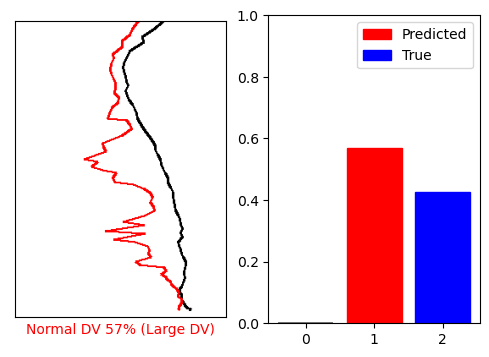

In [70]:
plt.figure(figsize=(6,4))
plt.subplot(1,2,1)
plot_image('2021052300', test_date, y_test_pred, y_test, test_img)
plt.subplot(1,2,2)
plot_prediction_bar('2021052300', test_date, y_test_pred, y_test, n_class)

plt.show()
plt.close()

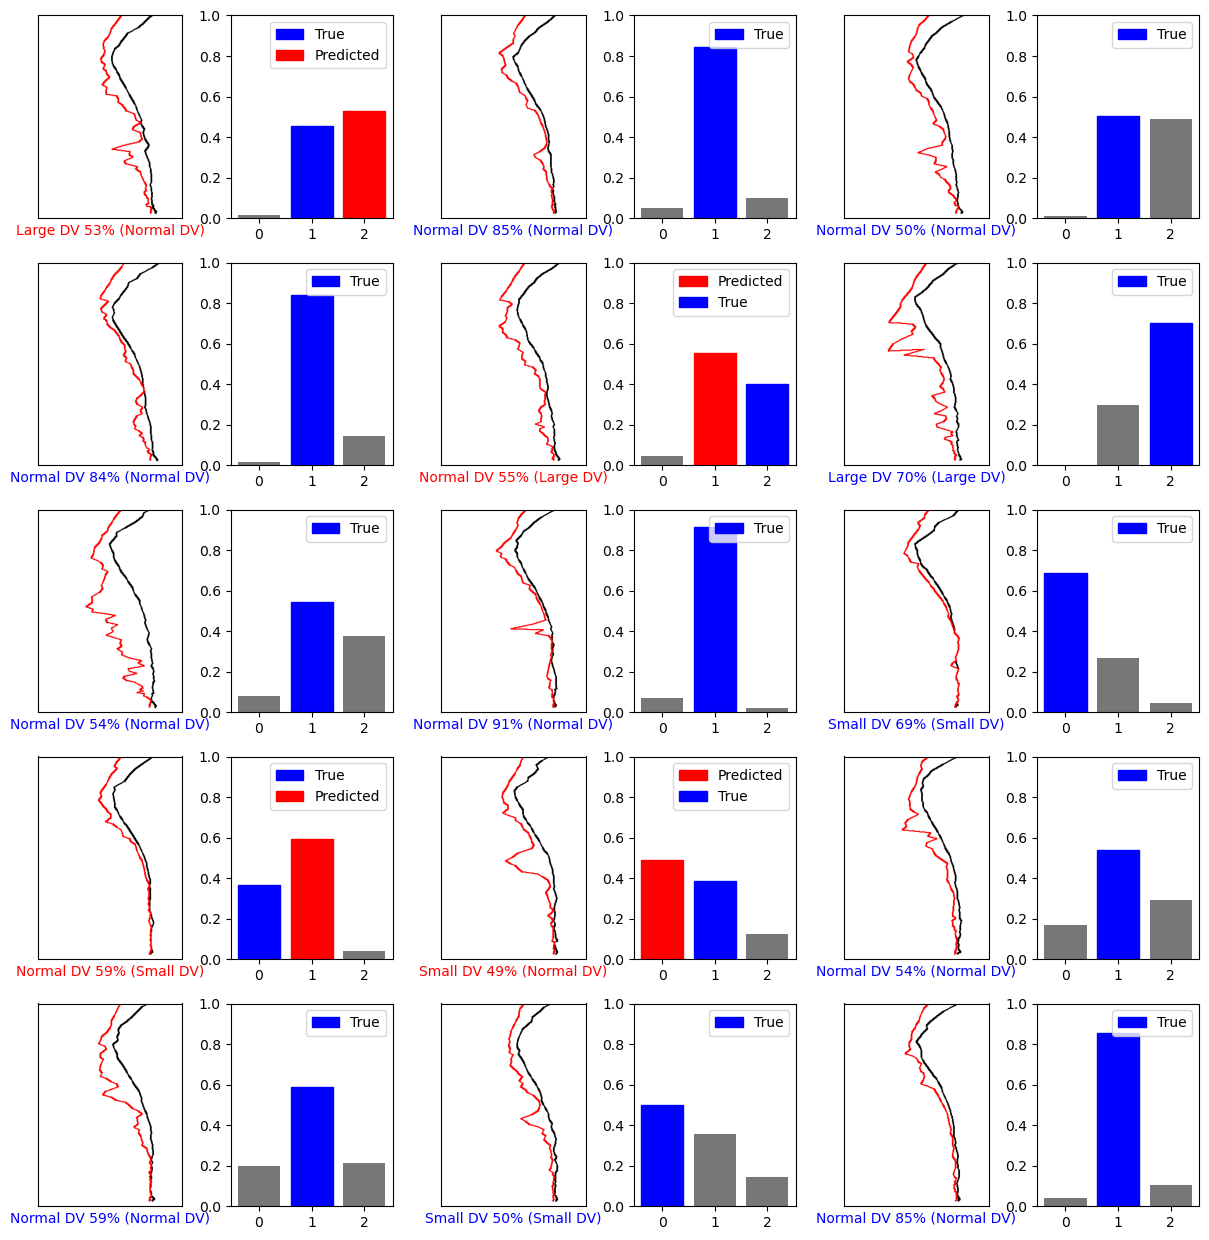

In [71]:
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2.5*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(test_date[i], test_date, y_test_pred, y_test, test_img)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_prediction_bar(test_date[i], test_date, y_test_pred, y_test, n_class)
    
plt.tight_layout()
plt.show()
plt.close()

### Plot comparison with CFO and OCF

In [73]:
def get_available_forecast_df(start_UTC='00'):
    _df_9day = pd.DataFrame()
    for lead_day in range(1, 10):
        ec_img = sorted(glob.glob(os.path.join(ver_dir, 'ec_tephi_data_{}Z_lead-{}d/*.png'.format(start_UTC, lead_day))))
        ec_date = [x.split('_')[-1].split('.')[0][:-4] + '00' for x in ec_img]
        _df = pd.DataFrame({'forecast_date':ec_date})
        _df['lead_day'] = lead_day
        _df_9day = pd.concat([_df_9day, _df], axis=0)
    return _df_9day

In [74]:
def get_cfo_performance(lead_day, df_dv, n_class):
    df_max = pd.read_csv('9day_maxT_forecast.csv')
    df_min = pd.read_csv('9day_minT_forecast.csv')

    column_max = 'D'+str(lead_day)+'_maxT'
    column_min = 'D'+str(lead_day)+'_minT'
    column_dv = 'D'+str(lead_day)+'_dv'

    df_9day = df_max.merge(df_min, on='date', how='inner')
    df_9day[column_dv] = df_9day[column_max] - df_9day[column_min]
    
    df_9day['forecast_date'] = df_9day['date'].shift(-lead_day)
    df_9day.dropna(inplace=True)
    df_9day['forecast_date'] = df_9day['forecast_date'].apply(lambda x: ''.join(x.split()[0].split('-')))
    df_9day['forecast_date'] = df_9day['forecast_date'] + '00'
    
    df_date = get_available_forecast_df()
    df_date = df_date[df_date['lead_day']==lead_day][['forecast_date']]
    
    df_9day = df_9day.merge(df_date, on='forecast_date', how='inner')
    df_9day['date'] = df_9day['forecast_date']
    
    DV_label = column_dv + '_label'
    df_9day[DV_label] = df_9day[column_dv].apply(lambda x: determine_dv_class(x, n_class))
    y_cfo = df_9day[DV_label].values

    df_dv = df_dv.merge(df_9day[['date']], on='date', how='inner')
    y_true = df_dv['dv_class'].values

    y_cfo_class = get_str_class(y_cfo, n_class)

    cfo_performance = get_result(y_cfo_class, y_true, to_file=None)
    return cfo_performance

In [75]:
def get_cfo_9day_result(df_dv, n_class):
    df_cfo_9day = pd.DataFrame()
    for lead_day in range(1, 10):
        day = pd.DataFrame({'day':[lead_day]*n_class})
        result = get_cfo_performance(lead_day, df_dv, n_class)
        df_one_day = pd.concat([day, result], axis=1)
        df_cfo_9day = pd.concat([df_cfo_9day, df_one_day], axis=0)
    return df_cfo_9day

In [76]:
def plot_result_comparison(df_model, df_cfo, df_ocf, utc='00', df_multi_model=None, multi_tephi=False, to_file=None):
    score = ['POD', 'FAR', 'CSI']
    classes = df_model['class'].unique()
    
    if utc == '00':
        x = np.arange(1, 10)
    elif utc == '12':
        if multi_tephi:
            x = np.arange(1, 9)
            df_model = df_model[df_model['day']<=8]
            df_cfo = df_cfo[df_cfo['day']<=8]
            df_ocf = df_ocf[df_ocf['day']<=8]
        else:
            x = np.arange(1, 10)
            
    if len(classes) == 3:
        fig, ax = plt.subplots(3, 3, sharex='col', figsize=(12, 8))
    elif len(classes) == 2:
        fig, ax = plt.subplots(3, 2, sharex='col', figsize=(8, 8))
    for i in range(len(score)):
        for j in range(len(classes)):
            ax[i][j].plot(x, df_model[df_model['class']==classes[j]][score[i]].values, '^-', label='Model')
            ax[i][j].plot(x, df_cfo[df_cfo['class']==classes[j]][score[i]].values, 'o-', label='CFO')
            ax[i][j].plot(x, df_ocf[df_ocf['class']==classes[j]][score[i]].values, 'o-', label='OCF')
            if df_multi_model is not None:
                ax[i][j].plot(x, df_multi_model[df_multi_model['class']==classes[j]][score[i]].values, 's-', label='New model')
            ax[i][j].set_ylim(0, 1)
            ax[i][j].set_xticks(x)
            ax[i][j].set_xticklabels([str(n) for n in x])
            ax[i][j].set_title(classes[j], fontsize=14)
            if i == 2:
                ax[i][j].set_xlabel('Forecast day', fontsize=15)
            if j == 0:
                ax[i][j].set_ylabel(score[i], fontsize=15)
                
            ax[i][j].legend(loc='center left', bbox_to_anchor=(1, 0.5))
            #ax[i][j].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
                            #fancybox=True, shadow=True, ncol=3)
                       
    plt.tight_layout()
    
    if to_file is not None:
        fig.savefig(to_file, bbox_inches="tight", pad_inches=0.2)

In [77]:
public_dir_model

'/home/deeplearn/public_html/20211125_gpu1_model_1216'

In [78]:
n_class

3

In [79]:
if n_class == 3:
    df_cfo = pd.read_csv('./cfo_9day_performance')
    df_ocf = pd.read_csv('./ocf_dv.csv')
elif n_class == 2:
    df_cfo = pd.read_csv('./cfo_9day_performance_binary')
    df_ocf = pd.read_csv('./ocf_binary_12Z.csv')

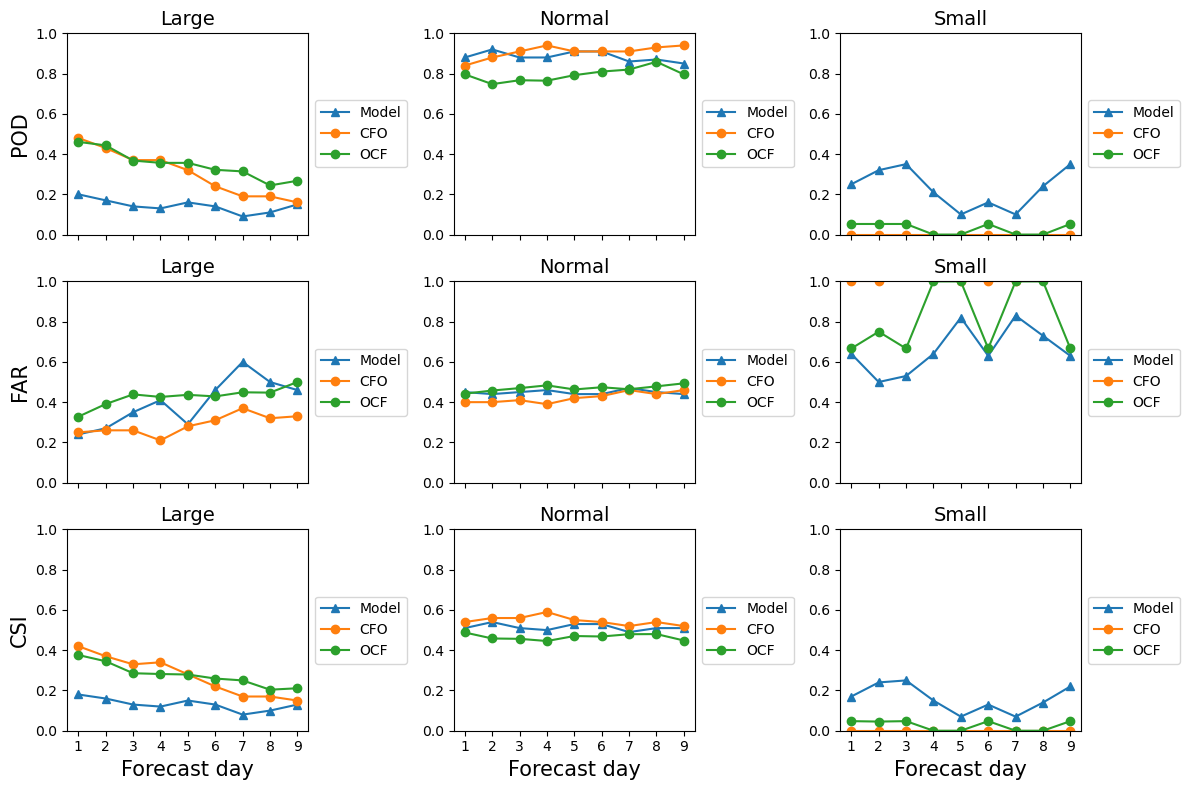

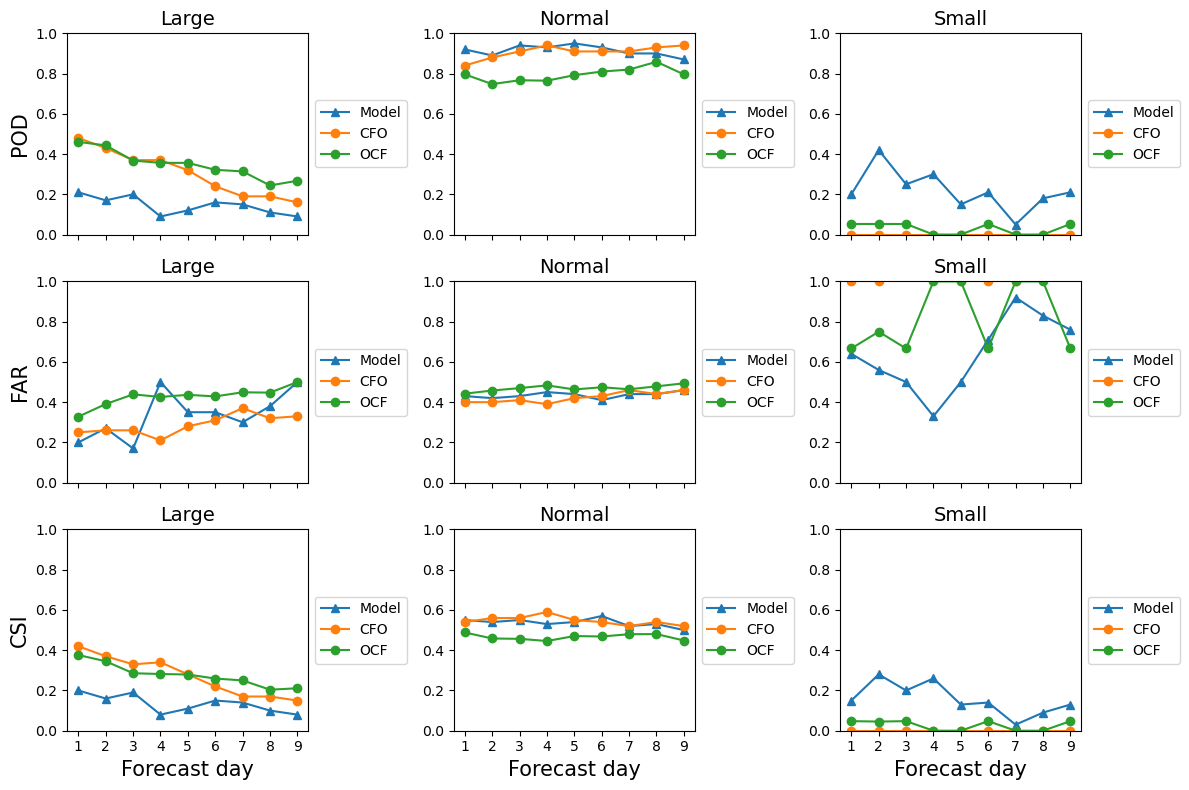

In [80]:
for utc in ['00', '12']:
    df_model = pd.read_csv(public_dir_model + '/model_9day_result_%sZ.csv' % utc)
    plot_result_comparison(df_model, df_cfo, df_ocf, utc, multi_tephi=False, to_file=os.path.join(public_dir_model, 'result_comparison_%sZ.png' % utc))
    plt.show()
    plt.close()

In [ ]:
'''
for utc in ['00', '12']:
    df_model = pd.read_csv('/home/deeplearn/public_html/20210930_gpu1_model_1242/model_9day_result_%sZ.csv' % utc)
    new_model = pd.read_csv('/home/deeplearn/public_html/20211011_gpu1_model_1836/model_9day_result_%sZ.csv' % utc)
    plot_result_comparison(df_model, df_cfo, df_ocf, utc, new_model, multi_tephi=False, to_file='/home/deeplearn/public_html/result_comparison_%sZ_v1.png' % utc)
    plt.show()
    plt.close()
'''

###